# Visualize "link graph" statistics and connected components

Follows up from the first phasing notebook.

In [1]:
%run "Header.ipynb"

In [2]:
import pickle
import shutil
import subprocess
import networkx as nx
from parse_sco import parse_sco

N = 10
# This probably won't save a noticeable amount of memory, but humor me
i2n = "ACGT"
n2i = {"A": 0, "C": 1, "G": 2, "T": 3}

## Utility functions

In [3]:
# Nodes in the graph are formatted as tuples of (pos, nt).
# When computing spans / etc., we'll need an easy way to access the position of these tuples.
# This is done using this simple lambda function. This also converts to 1-indexing, so positions can be easily
# compared with gene coordinates / etc.

get_pos = lambda allele_node: allele_node[0] + 1

def print_cc_info(topN_data, info):
    """Prints info about some value for the top N components in a graph.
    
    This is useful for, e.g., printing info about the top N components' node counts, edge counts,
    spans, etc. without repeating this code a bunch of times.
    
    Why don't we just print the topN_data list directly? Because we often want to use commas for the numbers
    in this list (since some components can have thousands of nodes/edges, for example). There's probably a simpler
    way to do this but whatevs.
    """
    print(f"\tComputed {info}:\n\t\t", end="")
    for cc_d in topN_data[:-1]:
        print(f"{cc_d:,}, ", end="")
    print(f"{topN_data[-1]:,}")
    
def node2gv(allele_node):
    """Converts a tuple of (pos, nucleotide) to an easily human-readable node in a graph.
    
    This will convert the position from 0 to 1-indexing using get_pos(), and it'll convert
    the nucleotide from an integer in the range [0, 3] to an actual nucleotide character (A/C/G/T).
    
    (The reason for conversion to 1-indexing is because other figures in the paper use 1-indexing.)
    
    e.g. node2gv((1234, 2)) -> '"1,235 (G)"'
    """
    
    return f'"{get_pos(allele_node):,} ({i2n[allele_node[1]]})"'

## Compute the $N$ largest components for each genome's graph, and plot some stats

($N$ was defined at the top of this notebook, fyi)

Computing stats for seq CAMP...
	Loaded graph.
	Computed top 10 ccs by node count:
		110, 105, 31, 30, 22, 20, 18, 17, 16, 15
	Computed numbers of edges in these top 10 ccs:
		3,473, 3,643, 172, 194, 152, 115, 76, 48, 48, 62
	Computed spans of these top 10 ccs:
		35,757, 35,566, 37,249, 28,391, 19,869, 14,465, 12,697, 23,080, 18,086, 8,741
Computing stats for seq BACT1...
	Loaded graph.
	Computed top 10 ccs by node count:
		24,780, 9,945, 9,935, 4,789, 1, 1
	Computed numbers of edges in these top 10 ccs:
		4,225,301, 1,943,873, 1,726,500, 1,122,948, 0, 0
	Computed spans of these top 10 ccs:
		2,150,722, 378,911, 433,398, 160,985, 1, 1
Computing stats for seq BACT2...
	Loaded graph.
	Computed top 10 ccs by node count:
		642, 303, 224, 199, 172, 164, 155, 122, 116, 114
	Computed numbers of edges in these top 10 ccs:
		11,454, 2,406, 2,123, 1,499, 6,725, 8,753, 1,426, 1,085, 891, 1,165
	Computed spans of these top 10 ccs:
		366,865, 242,889, 181,159, 183,742, 2,800,724, 23,557, 95,843, 10

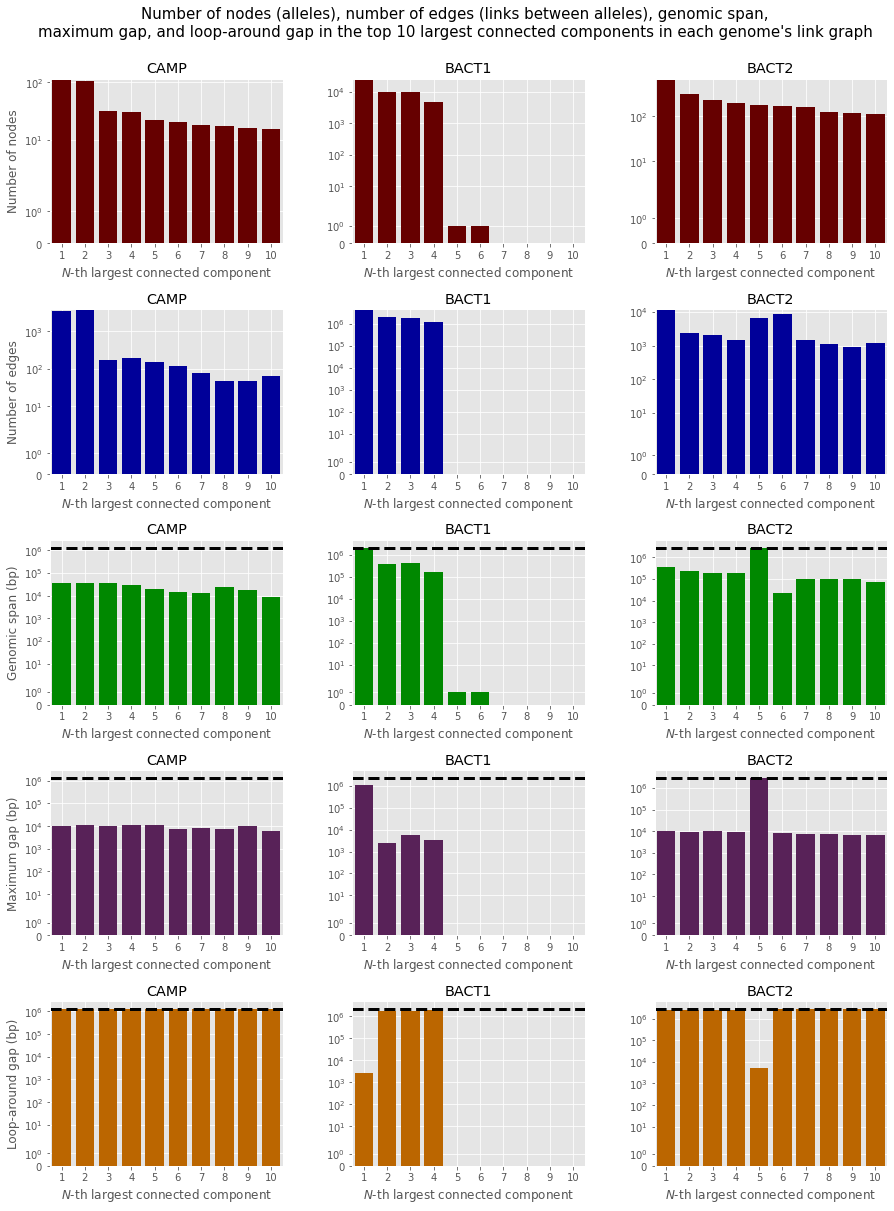

In [4]:
seq2topN_cc_subgraphs = {}
seq2sorted_cc_node_lists = {}
seq2topN_cc_spans = {}

gfig, gaxes = pyplot.subplots(5, 3, gridspec_kw={"hspace": 0.4, "wspace": 0.3})
for i, seq in enumerate(SEQS):
    print(f"Computing stats for seq {seq2name[seq]}...")
    
    with open(f"phasing-data/{seq}_linkgraph.pickle", "rb") as loadster:
        g = pickle.load(loadster)
        
    print("\tLoaded graph.")
    
    # nx.connected_components() returns a list of lists, where each inner list is just the nodes in
    # a given component.
    ccs = nx.connected_components(g)
    
    # Sort the connected component lists in descending order by number of nodes, and filter to the N ccs
    # with the largest #s of nodes (breaking ties arbitrarily)
    sorted_ccs = sorted(ccs, key=lambda cc: len(cc), reverse=True)
    topN_ccs = sorted_ccs[:N]
    seq2sorted_cc_node_lists[seq] = sorted_ccs
    
    topN_ccnodects = [len(cc) for cc in topN_ccs]
    
    print_cc_info(topN_ccnodects, f"top {N:,} ccs by node count")
    
    # Induce subgraphs for each of the top N components
    cc_subgraphs = [g.subgraph(cc) for cc in topN_ccs]
    seq2topN_cc_subgraphs[seq] = cc_subgraphs
    
    # To figure out the number of edges in this component, just look at the number of edges in the
    # corresponding subgraph
    topN_ccedgects = [len(subg.edges) for subg in cc_subgraphs]
    
    print_cc_info(topN_ccedgects, f"numbers of edges in these top {N:,} ccs")
    
    # Figure out spans of each component
    topN_ccspans = [get_pos(max(subg.nodes, key=get_pos)) - get_pos(min(subg.nodes, key=get_pos)) + 1 for subg in cc_subgraphs]
    seq2topN_cc_spans[seq] = topN_ccspans
    
    print_cc_info(topN_ccspans, f"spans of these top {N:,} ccs")
    
    # Figure out max gaps and looparounds for each component
    topN_ccmaxgaps = []
    topN_cclooparounds = []
    for scci, subg in enumerate(cc_subgraphs, 1):
        max_gap = 0
        looparound = 0
        if len(subg.nodes) > 1:
            snodes = sorted(subg.nodes, key=get_pos)
            
            for ni, p1 in enumerate(snodes[:-1]):
                # the -1 makes sure that this range is perfectly exclusive: neither p1 nor p2 are included
                # in the gap between them, whereas the span purposefully _includes_ both the rightmost and
                # leftmost positions. It doesn't make a huge difference, but the devil is in the details.
                gap = get_pos(snodes[ni + 1]) - get_pos(p1) - 1
                max_gap = max(max_gap, gap)
                
            # Looparounds -- we define this for all seqs (so, including CAMP/edge_6104), not just the two
            # circular ones.
            looparound = seq2len[seq] + get_pos(snodes[0]) - get_pos(snodes[-1]) - 1

        topN_ccmaxgaps.append(max_gap)
        topN_cclooparounds.append(looparound)
    
    axN = gaxes[0, i]
    axN.bar(range(1, len(topN_ccnodects) + 1), topN_ccnodects, color="#660000")
    
    axE = gaxes[1, i]
    axE.bar(range(1, len(topN_ccedgects) + 1), topN_ccedgects, color="#000099")
    
    axS = gaxes[2, i]
    axS.bar(range(1, len(topN_ccspans) + 1), topN_ccspans, color="#008800")
    
    axG = gaxes[3, i]
    axG.bar(range(1, len(topN_ccmaxgaps) + 1), topN_ccmaxgaps, color="#582258")
    
    axL = gaxes[4, i]
    axL.bar(range(1, len(topN_cclooparounds) + 1), topN_cclooparounds, color="#BB6600")
    
    if i == 0:
        axN.set_ylabel("Number of nodes")
        axE.set_ylabel("Number of edges")
        axS.set_ylabel("Genomic span (bp)")
        axG.set_ylabel("Maximum gap (bp)")
        axL.set_ylabel("Loop-around gap (bp)")
        #axS.set_ylabel("Genomic span:\nrightmost - leftmost + 1")
        #axG.set_ylabel("Maximum gap:\nmax(|$p_1 - p_2$| - 1) for all\nadjacent $p_1$, $p_2$ in sorted order")
        #axL.set_ylabel("Loop-around gap:\n gap from rightmost to leftmost,\nlooping around the genome")
       
    for ax in (axN, axE, axS, axG, axL):
        ax.set_title(seq2name[seq])
        ax.set_xlabel("$N$-th largest connected component")
        use_thousands_sep(ax.get_yaxis())
        ax.set_xlim(0.5, N + 0.5)
        # Based kind of on https://stackoverflow.com/a/28289136
        ax.set_xticks(range(1, N + 1))
        
        # Use a log scale on ALL of the plots. At first I was just gonna do this for the bottom 3 plots
        # (the same ones we draw the genome length line for), but at this point node / edge counts can wildly
        # vary within a given genome's top 10 components so it makes sense to just use log for everything.
        ax.set_yscale("symlog")
        
    # Show genome length for comparison on the span and gap plots
    for ax in (axS, axG, axL):
        ax.axhline(y=seq2len[seq], linestyle="--", color="black", linewidth=3,
                    label=f"{seq2name[seq]} length: {seq2len[seq]:,} bp")
        # The purpose of this line of code (which earlier-this-year-Marcus forgot to document)
        # is to ensure that there's enough space for the genome length horizontal line to be fully visible
        # (so that it doesn't get cut off by the top of the plot).
        ax.margins(y=0.05)
        
gfig.suptitle(
    (
        "Number of nodes (alleles), number of edges (links between alleles), "
        f"genomic span,\nmaximum gap, and loop-around gap in the top {N} largest connected components "
        "in each genome's link graph"
    ),
    fontsize="15",
    y=0.93
)
gfig.set_size_inches(15, 20)
gfig.savefig(f"figs/linkedmutgraph_top{N}cc_stats.png", bbox_inches="tight")

## Create Graphviz DOT files for the top $N$ largest components, coloring nodes by gene

We don't convert the DOT files to PNG yet, since that can take a while.

In [5]:
def get_gv_preamble(numnodes, use_prism=True):
    out_gv = " {\n"
    
    # DON'T use prism when using circo -- it causes weird things to happen to the graph layout, far as I
    # can tell. Like, it makes complete graphs look like these weird elliptical shapes instead of just
    # circles (case in point: CAMP cc1 as of writing)
    if use_prism:
        # Spend extra time trying to reduce node overlap
        out_gv += '\toverlap="prism50";\n'
    
    # Draw edges below nodes, so that it's easier to see all nodes (prevents occlusion of nodes by edges)
    out_gv += '\toutputorder="edgesfirst";\n'
    
    out_gv += '\tnode [style="filled"];\n'
    
    # Only add a label for graphs with < 1000 nodes. Past that, the labels will inflate the
    # file size and mess with the image when viewed at low resolution, so we don't bother adding a
    # label. (The default in Graphviz is for nodes to have labels -- see
    # http://www.graphviz.org/doc/info/attrs.html#d:label.)
    if numnodes >= 1000:
        out_gv += '\tnode [label=""];\n'
        
    # Lower the resolution of extra-large graphs to make it feasible to embed, e.g., the really big
    # BACT1 components. See https://stackoverflow.com/a/3918019.
    if numnodes >= 1000:
        out_gv += "\tdpi=20;\n"
        
    return out_gv

for seq in SEQS:
    genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
    
    num_genes = len(genes_df.index)
    
    # Get a quantitative color map, set up in such a way that there are G distinct colors sampled
    # along this color map from low to high (given G genes for a sequence). We'll assign each gene
    # a unique color from this map. See
    # https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html
    cmap = matplotlib.cm.get_cmap("viridis", num_genes)
    hexcolors = [matplotlib.colors.to_hex(cmap(c)) for c in range(num_genes)]
        
    total_seq_graph_gv = f"graph {seq}"
    total_seq_graph_num_nodes = sum([len(cc) for cc in seq2sorted_cc_node_lists[seq][:10]])
    print(seq, total_seq_graph_num_nodes, "nodes in the top 10 largest ccs")
    total_seq_graph_gv += get_gv_preamble(total_seq_graph_num_nodes)
    
    for cci in range(len(seq2topN_cc_subgraphs[seq])):
        
        subg = seq2topN_cc_subgraphs[seq][cci]
        
        numnodes = len(subg.nodes)
        numedges = len(subg.edges)
        span = seq2topN_cc_spans[seq][cci]
        
        # inefficient way of doing this - should ideally iterate through the nodes only once
        unique_genes = set()
        intergenic_ct = 0
        multi_ct = 0
        for n in subg.nodes:
            parent_genes = get_parent_gene_info_of_position(get_pos(n), genes_df)
            unique_genes.update(parent_genes)
            if len(parent_genes) == 0: intergenic_ct += 1
            elif len(parent_genes) > 1: multi_ct += 1
            
        num_ugs = len(unique_genes)
        if num_ugs > 1:
            ug = f"{num_ugs} unique genes"
        elif num_ugs == 1:
            ug = f"1 unique gene (#{next(iter(unique_genes))})"
        else:
            ug = "0 genes"
            
#         if intergenic_ct > 0:
#             ug += f" ({intergenic_ct} intergenic position"
#             if multi_ct > 1:
#                 ug += "s"
#             ug += ")"
        
        print(f"{seq2name[seq]}, cc {cci + 1}, {numnodes:,} nodes spanning {ug}, {numedges:,} edges, {span:,} bp span")
        
        graph_id = f"{seq2name[seq]}_cc{cci + 1}"
        gv = f"graph {graph_id}"
        
        # If you're using circo, it seems like using prism isn't a good idea (?)... but we're not using circo
        # at the moment, so just always use prism
        use_prism = True
            
        gv += get_gv_preamble(numnodes, use_prism=use_prism)
        
        # Add a nice label to each graph! https://stackoverflow.com/a/11594722
        gv += f'\tlabel="{seq2name[seq]}, component {cci + 1:,}: {numnodes:,} nodes spanning {ug}, {numedges:,} edges, {span:,} bp span";\n'
        gv += '\tlabelloc="t";\n'
        # Should probably be scaled better than this but it seems to work ok!
        if numnodes < 50:
            gv += '\tfontsize=24;\n'
        elif numnodes < 1000:
            gv += '\tfontsize=96;\n'
        else:
            gv += '\tfontsize=480;\n'
                
        for n in sorted(subg.nodes, key=get_pos):
            parent_gene_info = get_parent_gene_info_of_position(get_pos(n), genes_df)
            fontcolor = "#000000"
            if len(parent_gene_info) == 0:
                # Not-in-any-genes color is white (no overlap with viridis)
                genecolor = "#ffffff"
            elif len(parent_gene_info) > 1:
                # In-mulitple-genes color is gray (no overlap with viridis)
                genecolor = "#888888"
                # Just for debugging
                print(f"For reference: pos {n} in multiple genes in seq {seq2name[seq]}")
            else:
                # Nice! This position is unique to one gene.
                genecolor = hexcolors[(parent_gene_info[0] - 1)]
                
                # Color the font white to contrast with darker colors. We don't subtract 1 from the parent gene
                # number here since the number of genes is also 1-indexed. There's probs a fancier way to do this
                # but this should roughly match the decision made about text color for the mutation matrices,
                # and also it doesn't matter if this is slightly off -- as long as this is roughly on the right
                # track the text should look ok.
                if (parent_gene_info[0] / num_genes) < 0.5:
                    fontcolor = "#ffffff"
                
            nodename = node2gv(n)
            declbase = f'\t{nodename} [fillcolor="{genecolor}"'
            
            # Only give nodes a label if there are < 1000 nodes. Yes, we already set label="" globally above
            # when this is the case, but if we set the label to something else down here it'll override that
            # setting -- so we have to be careful not to assign a label for massive graphs (since the labels
            # are essentially unreadable in graphs with thousands of nodes, at least zoomed out far enough)
            if numnodes < 1000:
                rf_pct = 100 * subg.nodes[n]["relfreq"]
                # NOTE: the :-1 is a hack to get rid of the trailing double-quote, should remove need for this...
                nodelabel = f'{nodename[:-1]}\\n{subg.nodes[n]["freq"]:,}x ({rf_pct:.2f}%)"'
                nodedecl = f'{declbase}, label={nodelabel}, fontcolor="{fontcolor}"];\n'
            else:
                nodedecl = f'{declbase}];\n'
                
            gv += nodedecl
            total_seq_graph_gv += nodedecl
            
        for e in subg.edges:
            edgedecl = f'\t{node2gv(e[0])} -- {node2gv(e[1])}'
            
            # Only bother varying the edge thickness (penwidth) when there are < 1000 nodes.
            # Also, for reference, the "link" value should theoretically range from [0, 1]. There isn't
            # a ton of difference between 0 and 1 as Graphviz (AT LEAST ON THE VERSION I TESTED THIS ON AT
            # FIRST) draws them, so we scale these values by 5x so
            # the new range is [0, 5]. (Of course, for massive ~20,000 node components, these sorts of
            # variations aren't super visible, hence why we don't use penwidth then.)
            #
            # NOTE: Different versions of Graphviz seem to handle penwidth differently, so it may be worth
            # making these values adjustable. Newer versions seem to actually scale widths of 0.001 or so to
            # a point where the resulting lines are almost invisible (from testing, 0.001 is invisible to me,
            # and 0.01 is faintly visible) so we impose a lower clamp at 0.01. This makes the range actually
            # [0.01, 5] -- the implication is that if an edge has a link value of less than 0.01 / 5 = 0.002
            # then it'll be scaled up visually as if its link value was 0.002. I don't think the details matter
            # too much with this, but I'll add a note re: this in the paper.
            if numnodes < 1000:
                lw = 5 * subg.edges[e]["link"]
                LOWER_CLAMP = 0.01
                if lw < LOWER_CLAMP: lw = LOWER_CLAMP
                edgedecl += f' [penwidth={lw}]'
            
            edgedecl += ';\n'
            gv += edgedecl
            total_seq_graph_gv += edgedecl
            
        gv += "}"
        fnbase = f"graphs/{graph_id}"
        with open(fnbase + ".gv", "w") as ccgraphgvfile:
            ccgraphgvfile.write(gv)            
            
    total_seq_graph_gv += "}"
    
    fnbase = f"graphs/{seq2name[seq]}_top{N}_together"
    with open(fnbase + ".gv", "w") as ccgraphgvfile:
        ccgraphgvfile.write(total_seq_graph_gv)

edge_6104 384 nodes in the top 10 largest ccs
CAMP, cc 1, 110 nodes spanning 9 unique genes, 3,473 edges, 35,757 bp span
CAMP, cc 2, 105 nodes spanning 6 unique genes, 3,643 edges, 35,566 bp span
CAMP, cc 3, 31 nodes spanning 9 unique genes, 172 edges, 37,249 bp span
CAMP, cc 4, 30 nodes spanning 5 unique genes, 194 edges, 28,391 bp span
CAMP, cc 5, 22 nodes spanning 2 unique genes, 152 edges, 19,869 bp span
CAMP, cc 6, 20 nodes spanning 3 unique genes, 115 edges, 14,465 bp span
CAMP, cc 7, 18 nodes spanning 4 unique genes, 76 edges, 12,697 bp span
CAMP, cc 8, 17 nodes spanning 5 unique genes, 48 edges, 23,080 bp span
CAMP, cc 9, 16 nodes spanning 3 unique genes, 48 edges, 18,086 bp span
CAMP, cc 10, 15 nodes spanning 2 unique genes, 62 edges, 8,741 bp span
edge_1671 49451 nodes in the top 10 largest ccs
BACT1, cc 1, 24,780 nodes spanning 784 unique genes, 4,225,301 edges, 2,150,722 bp span
For reference: pos (268981, 2) in multiple genes in seq BACT1
For reference: pos (268981, 3) in 

### To make it possible to save and visualize these GV files elsewhere without breaking GitHub

The `gv.zip` archive includes all .gv files for the top 10 components of the three graphs. It excludes (using the `-x` argument of `zip` -- see [here](https://askubuntu.com/a/28482)) the three graphs representing all of these components at once in order to reduce the archive's filesize, since these three graphs don't add any extra information (they just make it more convenient to visualize multiple components in a single figure).

In [6]:
!zip -r graphs/gv.zip graphs/*.gv -x *together.gv

updating: graphs/BACT1_cc1.gv (deflated 91%)
updating: graphs/BACT1_cc2.gv (deflated 90%)
updating: graphs/BACT1_cc3.gv (deflated 89%)
updating: graphs/BACT1_cc4.gv (deflated 90%)
updating: graphs/BACT1_cc5.gv (deflated 27%)
updating: graphs/BACT1_cc6.gv (deflated 27%)
updating: graphs/BACT1_cc7.gv (deflated 27%)
updating: graphs/BACT2_cc10.gv (deflated 83%)
updating: graphs/BACT2_cc1.gv (deflated 83%)
updating: graphs/BACT2_cc2.gv (deflated 82%)
updating: graphs/BACT2_cc3.gv (deflated 82%)
updating: graphs/BACT2_cc4.gv (deflated 83%)
updating: graphs/BACT2_cc5.gv (deflated 87%)
updating: graphs/BACT2_cc6.gv (deflated 88%)
updating: graphs/BACT2_cc7.gv (deflated 83%)
updating: graphs/BACT2_cc8.gv (deflated 82%)
updating: graphs/BACT2_cc9.gv (deflated 83%)
updating: graphs/CAMP_cc10.gv (deflated 78%)
updating: graphs/CAMP_cc1.gv (deflated 86%)
updating: graphs/CAMP_cc2.gv (deflated 87%)
updating: graphs/CAMP_cc3.gv (deflated 80%)
updating: graphs/CAMP_cc4.gv (deflated 81%)
updating: gra

## Find "fates" of genes we care about in the graph

This looks at all components of the graph, so if a gene we care about has at least one mutated position it should be found here.

If you trace back how we created the graph in the previous notebook, you will see (at least, as of when I'm writing this in mid-October 2021) that the graph's nodes correspond to the mutated positions in `pos2nt2freq`, and that this dict is updated based on reads covering a mutated position with a match/mismatch operation. So... if a position is "mutated" but somehow no reads cover it with a match/mismatch, then this position won't be included as a node in the graph. But if that somehow happens, we proooooobably have other problems. (I just made a note to mention this in the paper / supplement / docs somewhere.)

In [8]:
seq2genes_we_esp_care_about = {
    "edge_6104": [1217],
    "edge_1671": [868],
    "edge_2358": [2561]
}
for seq in SEQS:
    
    print(f"Looking at genes {seq2genes_we_esp_care_about[seq]} for seq {seq2name[seq]}.")
    with open(f"phasing-data/{seq}_linkgraph.pickle", "rb") as loadster:
        g = pickle.load(loadster)
        
    genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
    genenums = seq2genes_we_esp_care_about[seq]
    for gn in genenums:
        ccs_with_positions_in_this_gene = []
        gene_data = genes_df.loc[gn]
        leftend = gene_data["LeftEnd"]
        rightend = gene_data["RightEnd"]
        
        # NOTE duplicated code from earlier in this notebook
        ccs = nx.connected_components(g)
        sorted_cc_node_list = sorted(ccs, key=lambda cc: len(cc), reverse=True)
        
        for cci, cc in enumerate(sorted_cc_node_list, 1):
            for node in cc:
                pos = get_pos(node)
                if pos >= leftend and pos <= rightend:
                    ccs_with_positions_in_this_gene.append(cci)
                    # Once we've observed this we can move on to the next cc
                    break
                    
        print(f"Gene {gn} in {seq2name[seq]}: mutated positions are located in cc(s) {ccs_with_positions_in_this_gene}.")
        
        # Copy plots to figs/ as needed.
#         for cci in ccs_with_positions_in_this_gene:
#             if cci <= N:
#                 shutil.copyfile(
#                     f"graphs/{seq2name[seq]}_cc{cci}.png",
#                     f"figs/{seq2name[seq]}_cc{cci}.png"
#                 )
#                 print(f"Copied cc {cci}'s plot to figs/ so you can include it in the paper.")
#             else:
#                 print(f"Couldn't copy cc {cci} to figs/ since wasn't plotted. Marcus needs to go plot it.")
        print("=" * 79)

Looking at genes [1217] for seq CAMP.
Gene 1217 in CAMP: mutated positions are located in cc(s) [1].
Looking at genes [868] for seq BACT1.
Gene 868 in BACT1: mutated positions are located in cc(s) [3].
Looking at genes [2561] for seq BACT2.
Gene 2561 in BACT2: mutated positions are located in cc(s) [5].


## Visualize DOT files as PNG files

This is done after outputting all the DOT files since this can take a while / might be best done on another machine (managing Graphviz installations is a bit challenging).

Currently, what I'm doing is running Graphviz on my laptop, because for some reason the Graphviz installation there works better than the one on our cluster. I have forgotten the reason why.

...But, uh, you can redo this step by checking out this repo, unzipping `gv.zip` (generated above) to a folder named `graphs/` (within the other `graphs/` folder... I know, I know), and then running `viz-graphs.py` to go through and run `sfdp` (one of the Graphviz layout programs) on the resulting `.gv` files to create `.png` files. Phew.

In [9]:
# for seq in SEQS:
#     # NOTE: this'll generate empty files for nonexistent components if the graph has < N ccs. not a big deal but
#     # should fix...
#     for cci in range(N):
#         graph_id = f"{seq2name[seq]}_cc{cci + 1}"
#         fnbase = f"graphs/{graph_id}"
        
#         prog = "sfdp"
            
#         print(f"Plotting cc {cci + 1} for seq {seq2name[seq]} using layout prog {prog}...")
#         with open(fnbase + ".png", "w") as ccgraphpngfile:
#             subprocess.run([
#                 prog,
#                 fnbase + ".gv",
#                 "-Tpng"
#             ],
#                 stdout=ccgraphpngfile
#             )

# #     if seq != "edge_1671":
# #         fnbase = f"graphs/{seq2name[seq]}_top{N}_together"
# #         print(f"Plotting full top {N} graph for {seq2name[seq]}...")
# #         with open(fnbase + ".png", "w") as ccgraphpngfile:
# #             subprocess.run([
# #                 "sfdp",
# #                 fnbase + ".gv",
# #                 "-Tpng"
# #             ],
# #                 stdout=ccgraphpngfile
# #             )
            
#     print(f"Done for seq {seq2name[seq]}.")

Plotting cc 1 for seq CAMP using layout prog sfdp...
Plotting cc 2 for seq CAMP using layout prog sfdp...
Plotting cc 3 for seq CAMP using layout prog sfdp...
Plotting cc 4 for seq CAMP using layout prog sfdp...
Plotting cc 5 for seq CAMP using layout prog sfdp...
Plotting cc 6 for seq CAMP using layout prog sfdp...
Plotting cc 7 for seq CAMP using layout prog sfdp...
Plotting cc 8 for seq CAMP using layout prog sfdp...
Plotting cc 9 for seq CAMP using layout prog sfdp...
Plotting cc 10 for seq CAMP using layout prog sfdp...
Done for seq CAMP.
Plotting cc 1 for seq BACT1 using layout prog sfdp...


KeyboardInterrupt: 